In [60]:
import numpy as np
import cv2
import os
import random
from skimage.io import imread
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D,MaxPooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from IPython.display import Audio

In [7]:
print("TensorFlow version :", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version : 2.11.0
Num GPUs Available:  0


In [10]:
train_dir = r"C:\Users\gaksh\Downloads\archive (1)\test"
test_dir = r"C:\Users\gaksh\Downloads\archive (1)\test"

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path +"/" +expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


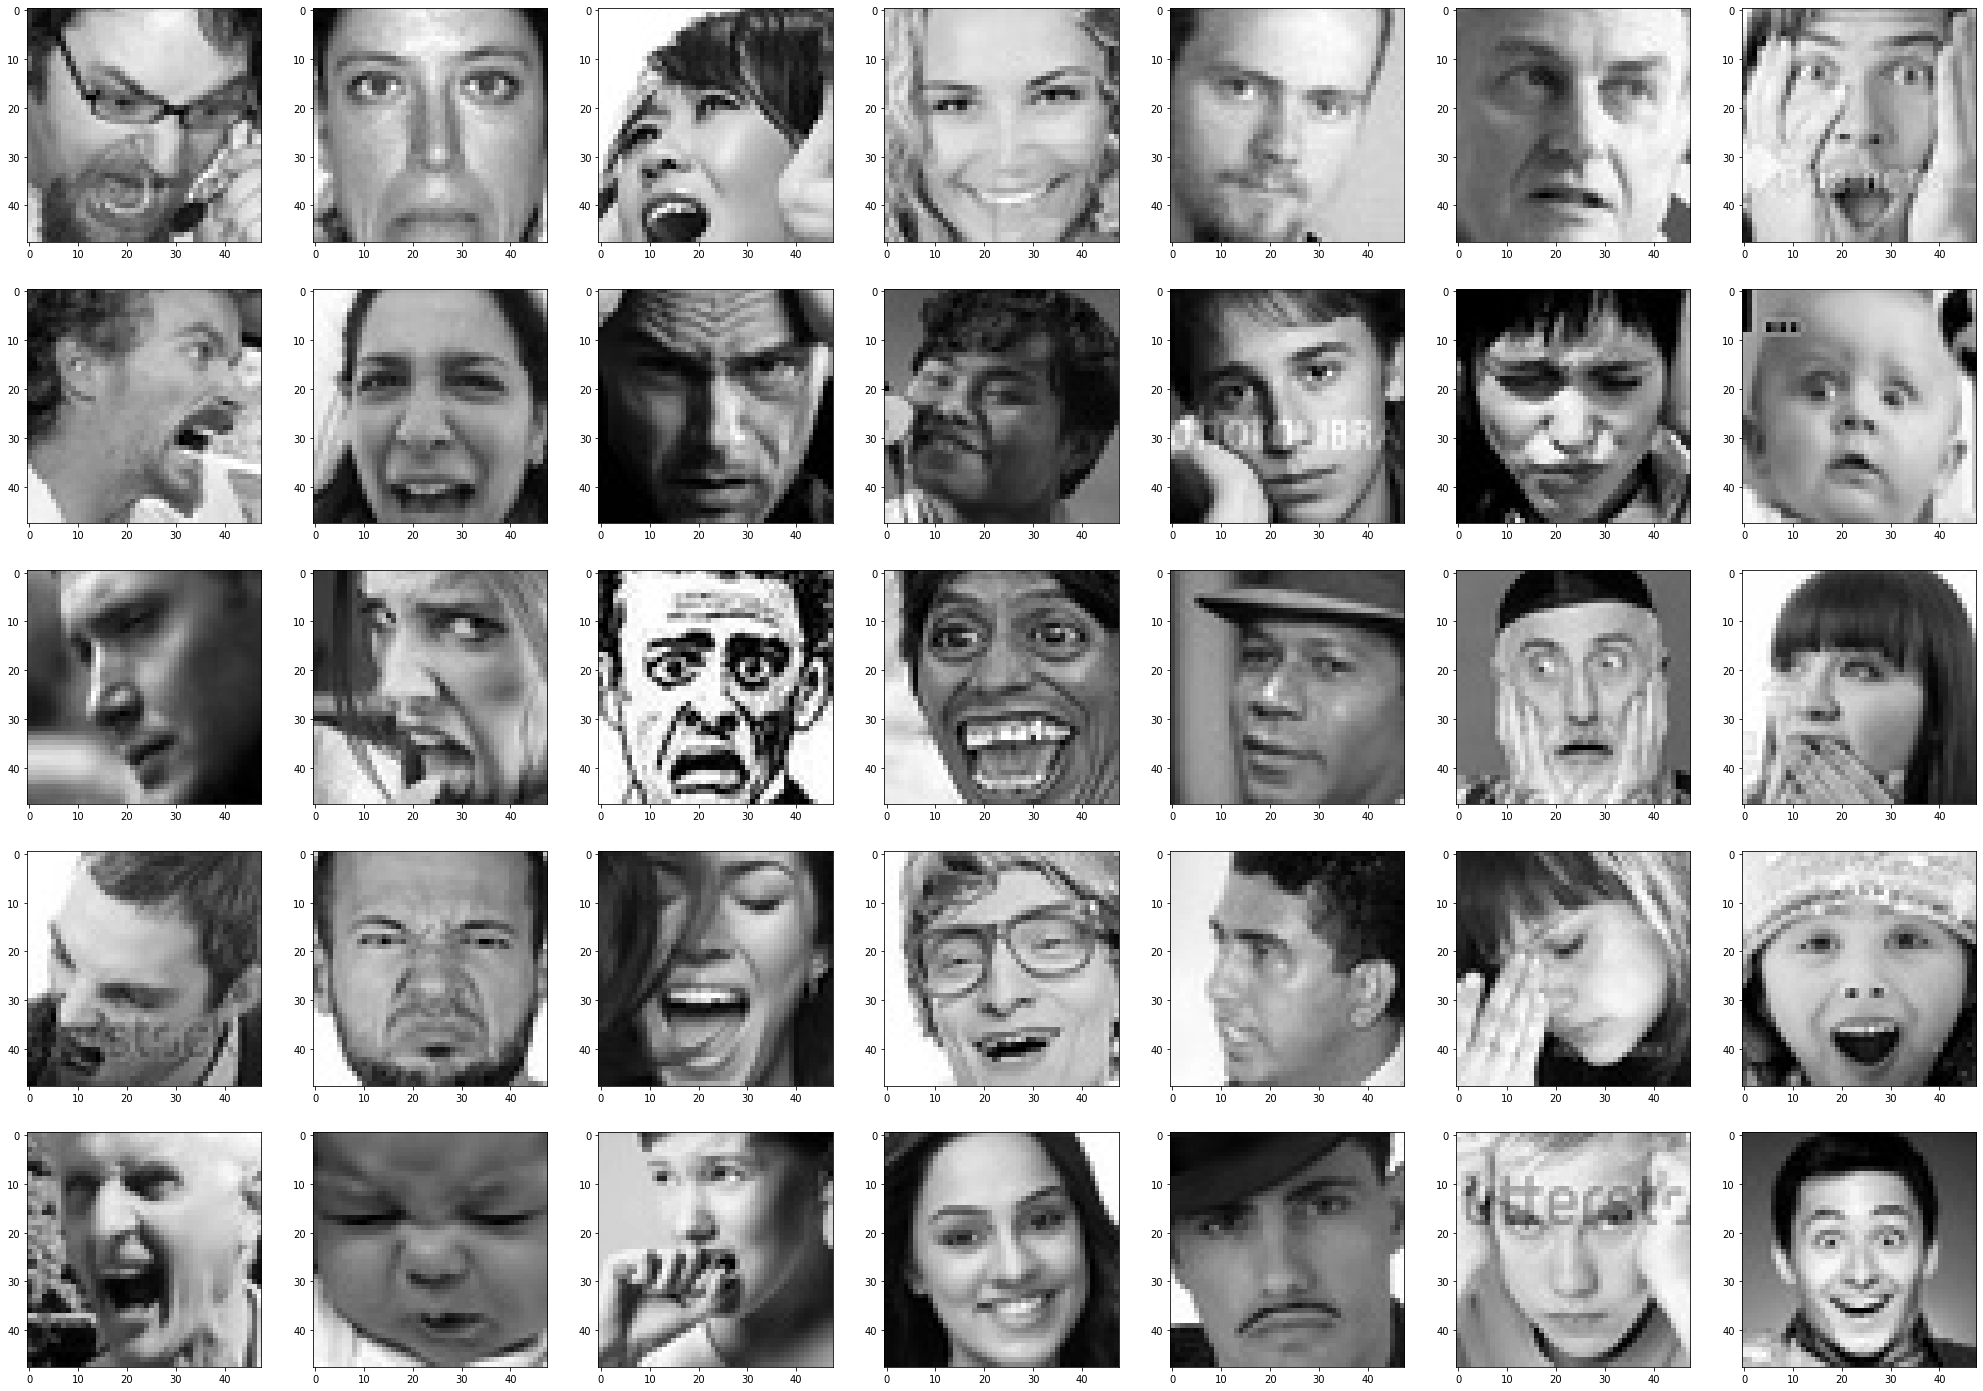

In [15]:
from skimage.io import imread
train_dir ="C:\\Users\\gaksh\\Downloads\\archive (1)\\test\\" 
test_dir = "C:\\Users\\gaksh\\Downloads\\archive (1)\\test\\"
total_labels = len(os.listdir(train_dir))

fig, ax = plt.subplots(nrows=5, ncols=total_labels, figsize=(35, 25))
for x in range(5):
    for y,v in zip(range(total_labels),os.listdir(train_dir)):
        ax[x][y].imshow(imread(train_dir+v+'/'+os.listdir(train_dir+v)[x]), cmap='gray')

plt.show()

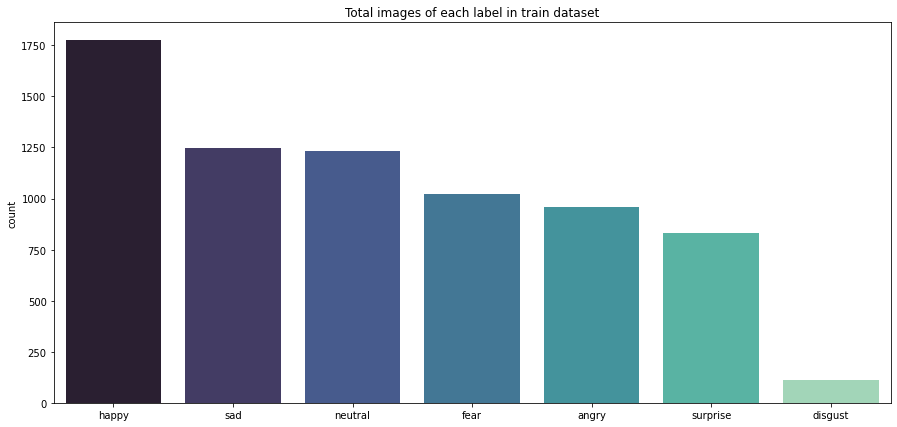

In [16]:
df = {}
for i in os.listdir(train_dir):
    directory = train_dir + i
    df[i] = len(os.listdir(directory))
df = pd.DataFrame(df, index=["total"]).transpose().sort_values("total", ascending=False)

plt.figure(figsize=(15,7))
sns.barplot(x=df.index, y="total", palette="mako", data=df)
plt.ylabel("count")
plt.title("Total images of each label in train dataset")
plt.show()

C:\Users\gaksh\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


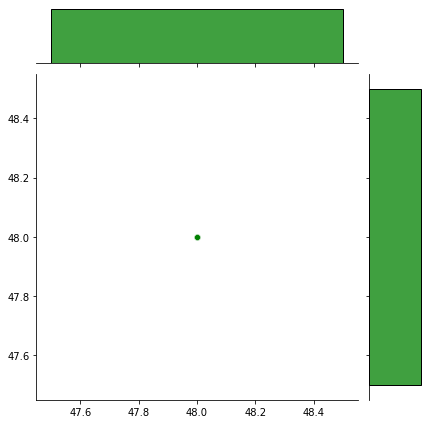

In [17]:
happy = os.listdir(train_dir+'happy/')
dim1, dim2 = [], []

for img_filename in happy:
    img = imread(train_dir+'happy/'+img_filename)
    d1, d2 = img.shape
    dim1.append(d1)
    dim2.append(d2)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)
sns.jointplot(dim1, dim2,color='g')
plt.show()

In [18]:
train_gen = ImageDataGenerator(rescale=1/255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1/255)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)

train_generator = train_gen.flow_from_directory(directory=train_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_gen.flow_from_directory(directory=test_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=False)

Found 7178 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [19]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=img_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=len(os.listdir(train_dir)), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 128)      5

In [26]:
 from math import exp
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [27]:
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = test_generator.n // test_generator.batch_size
num_epochs = 20

history = model.fit(train_generator,
                    epochs=num_epochs,
                    verbose=1,
                    #callbacks=callbacks,
                    validation_data=test_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/20
112/112 [==============================] - 256s 2s/step - loss: 2.0460 - accuracy: 0.2162 - val_loss: 2.0704 - val_accuracy: 0.2475
Epoch 2/20
112/112 [==============================] - 177s 2s/step - loss: 1.8505 - accuracy: 0.2288 - val_loss: 2.2721 - val_accuracy: 0.2475
Epoch 3/20
112/112 [==============================] - 178s 2s/step - loss: 1.8342 - accuracy: 0.2311 - val_loss: 2.0337 - val_accuracy: 0.2483
Epoch 4/20
112/112 [==============================] - 178s 2s/step - loss: 1.8187 - accuracy: 0.2405 - val_loss: 2.1935 - val_accuracy: 0.2483
Epoch 5/20
112/112 [==============================] - 176s 2s/step - loss: 1.8160 - accuracy: 0.2331 - val_loss: 2.0725 - val_accuracy: 0.2482
Epoch 6/20
112/112 [==============================] - 176s 2s/step - loss: 1.8040 - accuracy: 0.2518 - val_loss: 1.9251 - val_accuracy: 0.2582
Epoch 7/20
112/112 [==============================] - 177s 2s/step - loss: 1.8036 - accuracy: 0.2421 - val_loss: 1.8559 - val_accuracy: 0.2595

In [28]:
model.save("model.h5")

In [29]:
test_loss, test_acc = model.evaluate(test_generator)
print("validation accuracy :", str(test_acc*100)+"%")
print("validation loss :", test_loss)

113/113 [==============================] - 31s 273ms/step - loss: 1.6491 - accuracy: 0.3362
validation accuracy : 33.61660540103912%
validation loss : 1.6490646600723267


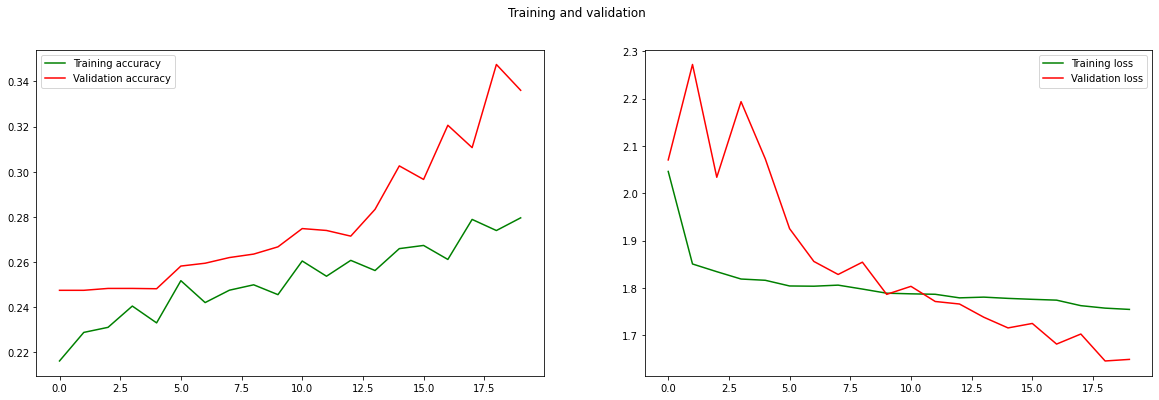

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'g', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'g', label='Training loss')
ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()

113/113 [==============================] - 30s 257ms/step
              precision    recall  f1-score   support

       angry       0.31      0.09      0.14       958
     disgust       0.00      0.00      0.00       111
        fear       0.26      0.03      0.06      1024
       happy       0.32      0.84      0.47      1774
     neutral       0.30      0.20      0.24      1233
         sad       0.28      0.15      0.20      1247
    surprise       0.53      0.44      0.48       831

    accuracy                           0.34      7178
   macro avg       0.29      0.25      0.23      7178
weighted avg       0.32      0.34      0.27      7178





C:\Users\gaksh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gaksh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gaksh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

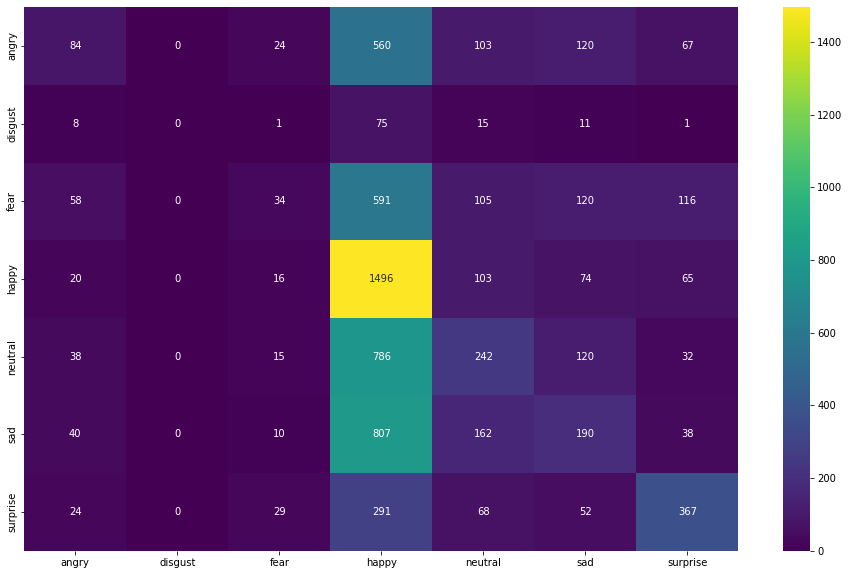

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(test_generator), axis=-1)
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()), end='\n\n\n')

cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(16,10))
sns.heatmap(cm, cmap=plt.cm.viridis, annot=True, fmt='.0f', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.show()

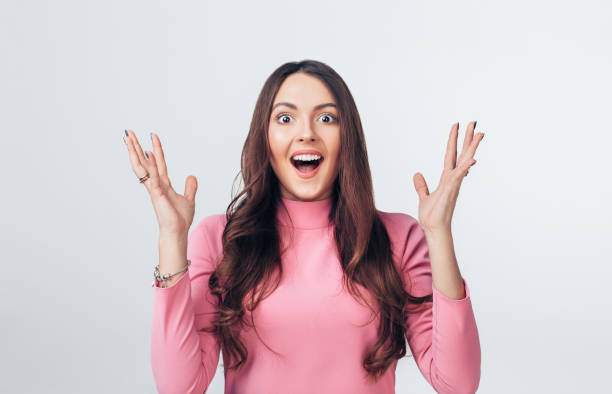

In [40]:
image = cv2.imread("C:\\Users\\gaksh\\Downloads\\archive (1)\\download.jpeg")
from IPython.display import Image
Image(filename="C:\\Users\\gaksh\\Downloads\\archive (1)\\download.jpeg")

In [44]:
import cv2
from tensorflow.python.keras.models import load_model
import os


# # load the trained model

model = tf.keras.models.load_model("model.h5",
    custom_objects={'Functional':tf.keras.models.Model})
# A list of emoticon categories
EMOTIONS = ['Angry', 'Disgust', 'Happy', 'Sad', 'Surprise', 'Neutral']
# Load image
img = image

# Trim the image to 48 x 48, and turn the grayscale image, normalization
frame = cv2.resize(img,(48,48),interpolation=cv2.INTER_BITS2)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255.0

# Reinvent the image dimension
gray = gray.reshape(1,48,48,1)

# Output the prediction
predicts = model.predict(gray)[0]
label = EMOTIONS[predicts.argmax()]
for (i,j) in zip(range(7),EMOTIONS):
    predictss = predicts[i]
    print("{:^10s}".format(j)+"prediction rate is   {0:.2f}%".format(predictss))
print( "\n\n The system considers this expression to be:",label)

1/1 [==============================] - 0s 251ms/step
  Angry   prediction rate is   0.22%
 Disgust  prediction rate is   0.01%
  Happy   prediction rate is   0.22%
   Sad    prediction rate is   0.17%
 Surprise prediction rate is   0.07%
 Neutral  prediction rate is   0.10%


 The system considers this expression to be: Happy


In [ ]:
if (label=='Angry'):
    path="C:\\Users\\gaksh\\Downloads\\archive (1)\\test\\angry\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='C:\\Users\\gaksh\\Downloads\\archive (1)\\Joker BGM Song Bass Boosted 2020(DjJpSwami.Com).mp3"'+ d,autoplay=True)
    display(audio)
    
elif (label=='Disgust'):
    path="C:\\Users\\gaksh\\Downloads\\archive (1)\\test\\disgust\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='C:\\Users\\gaksh\\Downloads\\archive (1)\\05. Rockstar.mp3"'+ d,autoplay=True)
    display(audio)
    
elif (label=="Happy"):
    path="C:\\Users\\gaksh\\Downloads\\archive (1)\\test\\happy"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename="C:\\Users\\gaksh\\Downloads\\archive (1)\\Maroon 5 -Memories Full Mp3 Song(RemixZilla.Com).mp3",autoplay=True)
    display(audio)
    
elif (label=='Sad'):
    path="C:\\Users\\gaksh\\Downloads\\archive (1)\\test\\sad\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='C:\\Users\\gaksh\\Downloads\\archive (1)\\Heat-Waves_320(PagalWorld).mp3"',autoplay=True)
    display(audio)
    
elif (label=='Surprise'):
    path="C:\\Users\\gaksh\\Downloads\\archive (1)\\test\\surprise\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='C:\\Users\\gaksh\\Downloads\\archive (1)\\Ignite---Alan-Walker-320-(PagalWorld).mp3"'+ d,autoplay=True)
    display(audio)
    
elif (label=='Neutral'):
    path="C:\\Users\\gaksh\\Downloads\\archive (1)\\test\\neutral\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='C:\\Users\\gaksh\\Downloads\\archive (1)\\On-and-On_320(PagalWorld).mp3"'+ d,autoplay=True)
    display(audio)

## Our Model has been successfully created

# Thank You !